<a href="https://www.bigdatauniversity.com"><img src="https://ibm.box.com/shared/static/cw2c7r3o20w9zn8gkecaeyjhgw3xdgbj.png" width="400" align="center"></a>

<h1 align="center"><font size="5">Classification with Python</font></h1>

In this notebook we try to practice all the classification algorithms that we learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Lets first load required libraries:

In [2]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

Lets download the dataset

In [3]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

--2019-05-03 10:35:43--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.193
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

100%[======================================>] 23,101      --.-K/s   in 0.07s   

2019-05-03 10:35:43 (304 KB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File  

In [4]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [10]:
df.shape


(346, 10)

### Convert to date time object 

In [8]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing



Let’s see how many of each class is in our data set 

In [12]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


Lets plot some columns to underestand data better:

In [13]:
# notice: installing seaborn might takes a few minutes
!conda install -c anaconda seaborn -y

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/DSX-Python35

  added / updated specs: 
    - seaborn


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2018.8.24          |           py35_1         139 KB  anaconda
    seaborn-0.9.0              |           py35_0         378 KB  anaconda
    openssl-1.0.2r             |       h7b6447c_0         3.2 MB  anaconda
    ca-certificates-2019.1.23  |                0         126 KB  anaconda
    ------------------------------------------------------------
                                           Total:         3.8 MB

The following packages will be UPDATED:

    ca-certificates: 2019.1.23-0          --> 2019.1.23-0       anaconda
    certifi:         2018.8.24-py35_1     --> 2018.8.24-py35_1  anaconda
    openssl:         1.0.2p-h14c3975_0    --> 1.0.2r-h7b6447c_0 anaconda
    seaborn:         0

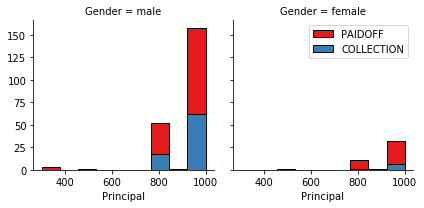

In [20]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g=sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

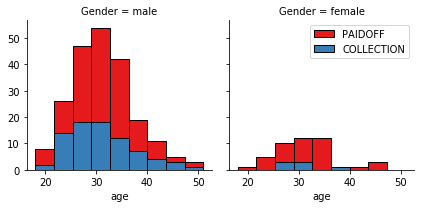

In [21]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction

### Lets look at the day of the week people get the loan 

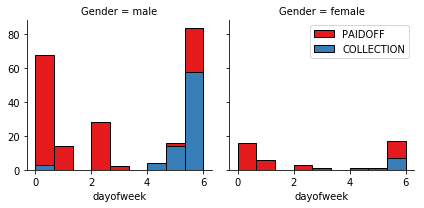

In [25]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 

In [31]:
df['weekend'] = df['dayofweek'].map(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values

Lets look at gender:

In [38]:
# df.groupby(['Gender']).loan_status.value_counts(normalize=True)
df.groupby(df.Gender).loan_status.value_counts()

Gender  loan_status
female  PAIDOFF         45
        COLLECTION       7
male    PAIDOFF        215
        COLLECTION      79
Name: loan_status, dtype: int64

86 % of female pay there loans while only 73 % of males pay there loan


Lets convert male to 0 and female to 1:


In [41]:
# df.Gender.replace(['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding  
#### How about education?

In [45]:
df.groupby('education').loan_status.value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Feature befor One Hot Encoding

In [46]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame 

In [47]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature selection

Lets defind feature sets, X:

In [57]:
X = Feature
X[0:5]
X.dtypes

Principal               int64
terms                   int64
age                     int64
Gender                  int64
weekend                 int64
Bechalor                uint8
High School or Below    uint8
college                 uint8
dtype: object

What are our lables?

In [69]:
df.loan_status.replace(['PAIDOFF','COLLECTION'], value=[1,0],inplace=True)
y = df['loan_status']
y.unique()



array([1, 0])

## Normalize Data 

Data Standardization give data zero mean and unit variance (technically should be done after train test split )

In [70]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Classification 

Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:
- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression



__ Notice:__ 
- You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
- You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
- You should include the code of the algorithm in the following cells.

# K Nearest Neighbor(KNN)
Notice: You should find the best k to build the model with the best accuracy.  
**warning:** You should not use the __loan_test.csv__ for finding the best k, however, you can split your train_loan.csv into train and test to find the best __k__.

In [265]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=0)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)



Train set: (276, 8) (276,)
Test set: (70, 8) (70,)


The best accuracy was with  0.757142857143 with k= 7


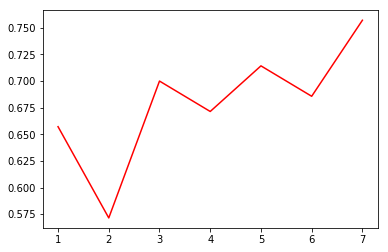

In [288]:
from sklearn.neighbors import KNeighborsClassifier
i=8
accu1 = []
for i in range(1,i):
    neighbors = KNeighborsClassifier(n_neighbors = i).fit(X_train, y_train)
    accu1.append(neighbors.score(X_test, y_test))
accu1= np.array(accu1) 
plt.plot(range(1, 8),accu1,'red')
print("The best accuracy was with " ,accu1.max(),"with k=" ,accu1.argmax()+1 ) 
neighbors = KNeighborsClassifier(n_neighbors = 7).fit(X_train, y_train)


# Decision Tree

The best accuracy was with  0.828571428571 with k= 1


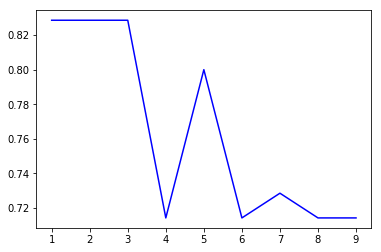

In [282]:
from sklearn.tree import DecisionTreeClassifier
j=10
accu2 = []
for j in range(1,j):
    dtree = DecisionTreeClassifier(criterion = "entropy", max_depth = j, random_state=0).fit(X_train, y_train)
    accu2.append(dtree.score(X_test, y_test))
accu2= np.array(accu2) 

plt.plot(range(1, 10),accu2,'blue')
print("The best accuracy was with " ,accu2.max(),"with k=" ,accu2.argmax()+1 ) 
dtree = DecisionTreeClassifier(criterion = "entropy", max_depth = 1, random_state=0).fit(X_train, y_train)


# Support Vector Machine

The best accuracy was with  0.828571428571 with k= 1


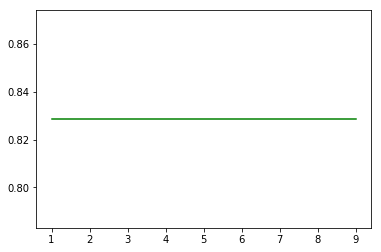

In [283]:
from sklearn import svm
k=10
accu3 = []
for k in range(1,k):
    sv = svm.SVC(kernel='linear', C=k, random_state=0).fit(X_train, y_train)
    accu3.append(sv.score(X_test, y_test))
accu3= np.array(accu3) 

plt.plot(range(1,10),accu3,'green')
print("The best accuracy was with " ,accu3.max(),"with k=" ,accu3.argmax()+1 ) 
sv = svm.SVC(kernel='linear', C=1, random_state=0).fit(X_train, y_train)

# Logistic Regression

The best accuracy was with  0.842857142857 with k= 1


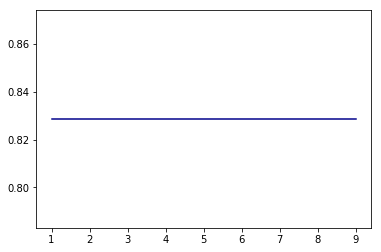

In [284]:
from sklearn.linear_model import LogisticRegression
l=10
accu4 = []
for l in range(1,l):
    logr = LogisticRegression(C=l, random_state=0).fit(X_train,y_train)
    accu4.append(logr.score(X_test,y_test))
accu4=np.array(accu4)
plt.plot(range(1,10),accu3,'DarkBlue')
print("The best accuracy was with " ,accu4.max(),"with k=" ,accu4.argmax()+1 ) 
logr = LogisticRegression(C=1, random_state=0).fit(X_train,y_train)

# Model Evaluation using Test set

In [20]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss



First, download and load the test set:

In [142]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2019-05-03 12:56:06--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.193
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

100%[======================================>] 3,642       --.-K/s   in 0s      

2019-05-03 12:56:06 (601 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Test set for evaluation 

In [291]:
df1 = pd.read_csv('loan_test.csv')
# df1

# # ## as Principal','terms','age','Gender','weekend' should be our features,and all should be numerical, so lets do some transofrmation.
# # ## convert dates form object to date type
df1.due_date = pd.to_datetime(df1.due_date)
df1.effective_date = pd.to_datetime(df1.effective_date)
df1.head()
df1.dtypes
# # ## creating a new weekend field now
df1['dayofweek'] = df1.effective_date.dt.dayofweek
df1["weekend"] = df1.dayofweek.map(lambda x: 1 if (x>3)  else 0 )

# # ## now gender to be converted to numerical data from categorical
df1.Gender.replace(["male", "female"], value=[0,1], inplace=True)
df1.head()

newFeature = df1[['Principal','terms','age','Gender','weekend']]

newFeature = pd.concat([newFeature, pd.get_dummies(df1.education)], axis=1)

newFeature.drop(['Master or Above'],axis=1, inplace=True)
# newFeature
X_test_new = newFeature

X_test_new = preprocessing.StandardScaler().fit(X_test_new ).transform(X_test_new )
# X_test_new
df1.loan_status.replace(['PAIDOFF','COLLECTION'], value=[1,0],inplace=True)
y_test_new = df1.loan_status.values
# y_test_new
from sklearn.metrics import jaccard_similarity_score, f1_score, log_loss 
print("**************************KNN****************************")
print("jaccard_similarity_score for KNN is ", jaccard_similarity_score(y_test_new, neighbors.predict(X_test_new)))
print("F1 Score for KNN is ", f1_score(y_test_new, neighbors.predict(X_test_new), average='weighted') )
print("log loss score for KNN is  NA")
print("**************************DTREE****************************")

print("jaccard_similarity_score for DTREE is ", jaccard_similarity_score(y_test_new, dtree.predict(X_test_new)))
print("F1 Score for dtree is ", f1_score(y_test_new, dtree.predict(X_test_new), average='weighted') )
print("log loss score for dtree is N/A")

print("**************************SVM****************************")
print("jaccard_similarity_score for SVM is ", jaccard_similarity_score(y_test_new, sv.predict(X_test_new)))
print("F1 Score for SVM is ", f1_score(y_test_new, sv.predict(X_test_new), average='weighted') )
print("log loss score for SVM is N/A" )

print("**************************LOGISTIC****************************")
print("jaccard_similarity_score for LOGISTIC is ", jaccard_similarity_score(y_test_new, logr.predict(X_test_new)))
print("F1 Score for LOGISTIC is ", f1_score(y_test_new, logr.predict(X_test_new), average='weighted') )
print("log loss score for LOGISTIC is ", log_loss(y_test_new, logr.predict(X_test_new)) )

**************************KNN****************************
jaccard_similarity_score for KNN is  0.722222222222
F1 Score for KNN is  0.700198920148
log loss score for KNN is  NA
**************************DTREE****************************
jaccard_similarity_score for DTREE is  0.740740740741
F1 Score for dtree is  0.630417651694
log loss score for dtree is N/A
**************************SVM****************************
jaccard_similarity_score for SVM is  0.740740740741
F1 Score for SVM is  0.630417651694
log loss score for SVM is N/A
**************************LOGISTIC****************************
jaccard_similarity_score for LOGISTIC is  0.740740740741
F1 Score for LOGISTIC is  0.630417651694
log loss score for LOGISTIC is  8.9547048869


/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# Report
You should be able to report the accuracy of the built model using different evaluation metrics:

| Algorithm          | Jaccard | F1-score | LogLoss |
|--------------------|---------|----------|---------|
| KNN                | 0.72    | 0.70     | NA      |
| Decision Tree      | 0.74    | 0.63     | NA      |
| SVM                | 0.74    | 0.63     | NA      |
| LogisticRegression | 0.74    | 0.63     | 8.95    |

<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

<p>Copyright &copy; 2018 <a href="https://cocl.us/DX0108EN_CC">Cognitive Class</a>. This notebook and its source code are released under the terms of the <a href="https://bigdatauniversity.com/mit-license/">MIT License</a>.</p>